In [86]:
%reload_ext autoreload
%autoreload 2
%autosave 1
%matplotlib inline

Autosaving every 1 seconds


In [87]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt # Visualization
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler
import torch # Library for implementing Deep Neural Network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import lightning as L

from api.api_cache import session
from model.predictor import LSTMModel, LitLSTMModel

In [112]:
# Loading the Apple.Inc Stock Data

import yfinance as yf
from datetime import date, timedelta, datetime

end_date = date.today().strftime("%Y-%m-%d") #end date for our data retrieval will be current date
start_date = '1990-01-01' # Beginning date for our historical data retrieval

df = yf.download('AAPL', start=start_date, end=end_date, session=session)# Function used to fetch the data
df.info()

[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8610 entries, 1990-01-02 to 2024-03-06
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       8610 non-null   float64
 1   High       8610 non-null   float64
 2   Low        8610 non-null   float64
 3   Close      8610 non-null   float64
 4   Adj Close  8610 non-null   float64
 5   Volume     8610 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 470.9 KB


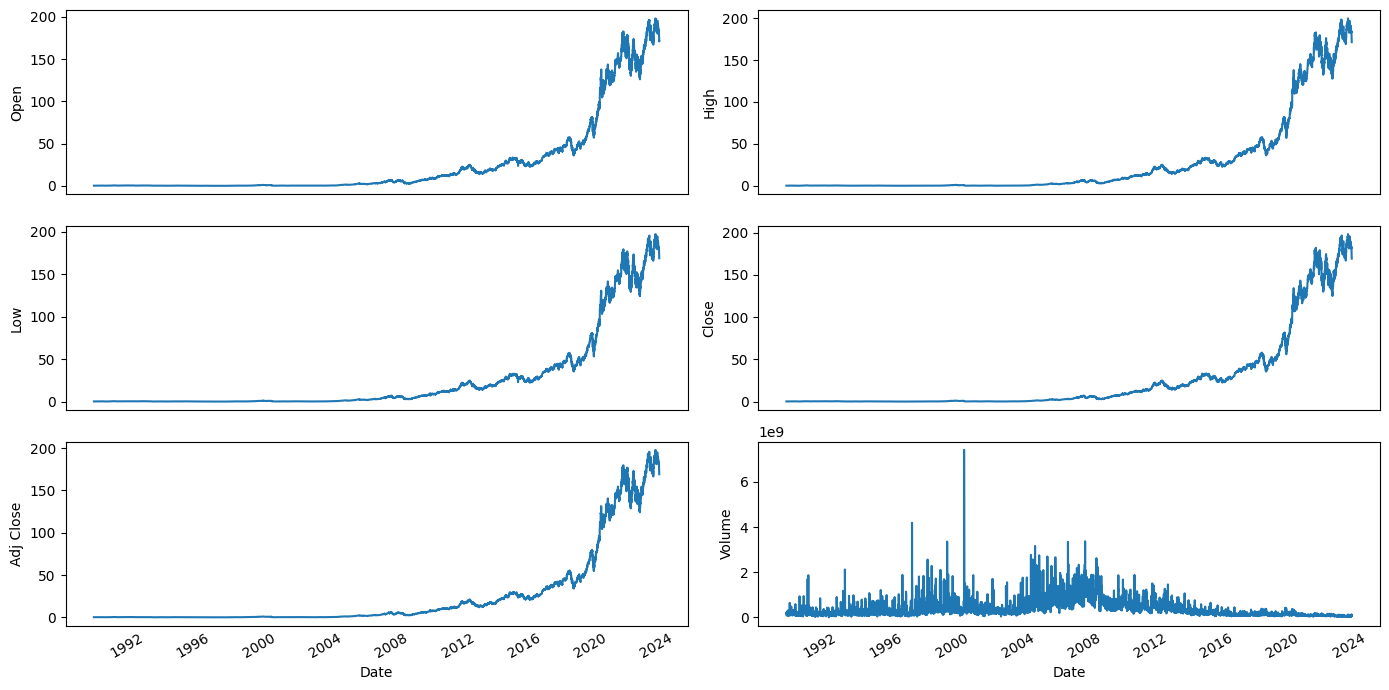

In [89]:
def data_plot(df):
    df_plot = df.copy()

    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                           sharex=True, figsize=(14, 7))
    for i, ax in enumerate(fig.axes):
        sns.lineplot(data=df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    plt.show()

data_plot(df)

In [90]:
# Train-Test Split
# Setting 80 percent data for training
training_data_len = math.ceil(len(df) * .8)
training_data_len

#Splitting the dataset
train_data = df[:training_data_len].iloc[:,:1]
test_data = df[training_data_len:].iloc[:,:1]
print(train_data.shape, test_data.shape)

(6888, 1) (1722, 1)


In [91]:
# Selecting Open Price values
dataset_train = train_data.Open.values
# Reshaping 1D to 2D array
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(6888, 1)

In [92]:
# Selecting Open Price values
dataset_test = test_data.Open.values
# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1,1))
dataset_test.shape

(1722, 1)

In [93]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_train = scaler.fit_transform(dataset_train)

print(scaled_train[:5])
# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(dataset_test)
print(*scaled_test[:5]) #prints the first 5 rows of scaled_test

[[0.00543315]
 [0.00610092]
 [0.00616162]
 [0.00604022]
 [0.00597949]]
[0.00414369] [0.00557628] [0.00594596] [0.00944269] [0.01689824]


In [94]:
# Create sequences and labels for training data
sequence_length = 50  # Number of time steps to look back
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i+sequence_length])
    y_train.append(scaled_train[i+1:i+sequence_length+1])

X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train[0])

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_train.shape,y_train.shape

[[0.00543315]
 [0.00610092]
 [0.00616162]
 [0.00604022]
 [0.00597949]
 [0.00610092]
 [0.00600987]
 [0.00567598]
 [0.00519034]
 [0.00525104]
 [0.00500821]
 [0.00531174]
 [0.0048868 ]
 [0.00506891]
 [0.00512961]
 [0.00506891]
 [0.0047654 ]
 [0.00519034]
 [0.00512961]
 [0.0048868 ]
 [0.00494751]
 [0.00525104]
 [0.00525104]
 [0.00494751]
 [0.00519034]
 [0.00531174]
 [0.0048868 ]
 [0.00494751]
 [0.00500821]
 [0.00519034]
 [0.00512961]
 [0.00525104]
 [0.00506891]
 [0.00519034]
 [0.00500821]
 [0.0048261 ]
 [0.00512961]
 [0.0048261 ]
 [0.0048868 ]
 [0.00512961]
 [0.00500821]
 [0.00500821]
 [0.00500821]
 [0.00500821]
 [0.00537244]
 [0.00537244]
 [0.00555455]
 [0.00579738]
 [0.00591879]
 [0.00573668]]


(torch.Size([6838, 50, 1]), torch.Size([6838, 50, 1]))

In [95]:
# Create sequences and labels for testing data
sequence_length = 30  # Number of time steps to look back
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i+sequence_length])
    y_test.append(scaled_test[i+1:i+sequence_length+1])
X_test, y_test = np.array(X_test), np.array(y_test)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_test.shape, y_test.shape

(torch.Size([1692, 30, 1]), torch.Size([1692, 30, 1]))

In [100]:
class LitLSTMModel(L.LightningModule):
    # input_size : number of features in input at each time step
    # hidden_size : Number of LSTM units
    # num_layers : number of LSTM layers
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        self.apply(self._weights_init)

    def _weights_init(self, m):
        if isinstance(m, nn.LSTM):
            for name, param in m.named_parameters():
                if "weight" in name:
                    nn.init.xavier_normal_(param.data)
                elif "bias" in name:
                    nn.init.constant_(param.data, 0)

    def forward(self, x):  # defines forward pass of the neural network
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out

    def training_step(self, batch, batch_idx, validation=False):
        X, y = batch
        y_hat = self(X)
        loss = torch.nn.functional.mse_loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=not validation)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.mse_loss(y_hat, y)
        preds = y_hat

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [101]:
input_size = 1
num_layers = 2
hidden_size = 64
output_size = 1

# Define the model, loss function, and optimizer
lit_model = LitLSTMModel(input_size, hidden_size, num_layers)
print(type(lit_model))

<class '__main__.LitLSTMModel'>


In [102]:
batch_size = 16
# Create DataLoader for batch training
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for batch training
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [107]:
trainer = L.Trainer(limit_train_batches=100, max_epochs=10, min_epochs=3, gradient_clip_val=0.5, deterministic=True, detect_anomaly=True)
trainer.fit(model=lit_model, train_dataloaders=train_loader, val_dataloaders=test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type   | Params
----------------------------------
0 | lstm   | LSTM   | 50.4 K
1 | linear | Linear | 65    
----------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)


/home/manuel/Projects/StockPredictor/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/manuel/Projects/StockPredictor/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 100/100 [00:02<00:00, 38.72it/s, v_num=6, train_loss=6.75e-5, val_loss=0.000406]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 100/100 [00:02<00:00, 38.62it/s, v_num=6, train_loss=6.75e-5, val_loss=0.000406]


In [108]:
# Define the number of future time steps to forecast
num_forecast_steps = 30

# Convert to NumPy and remove singleton dimensions
sequence_to_plot = X_test.squeeze().cpu().numpy()

# Use the last 30 data points as the starting point
historical_data = sequence_to_plot[-1]

# Initialize a list to store the forecasted values
forecasted_values = []

# Use the trained model to forecast future values
with torch.no_grad():
    for _ in range(num_forecast_steps*2):
        # Prepare the historical_data tensor
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float()
        # Use the model to predict the next value
        predicted_value = lit_model(historical_data_tensor).cpu().numpy()[0, 0]

        # Append the predicted value to the forecasted_values list
        forecasted_values.append(predicted_value[0])

        # Update the historical_data sequence by removing the oldest value and adding the predicted value
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value


# Generate futute dates
last_date = test_data.index[-1]

# Generate the next 30 dates
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)

# Concatenate the original index with the future dates
combined_index = test_data.index.append(future_dates)

/tmp/ipykernel_43505/877972250.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value


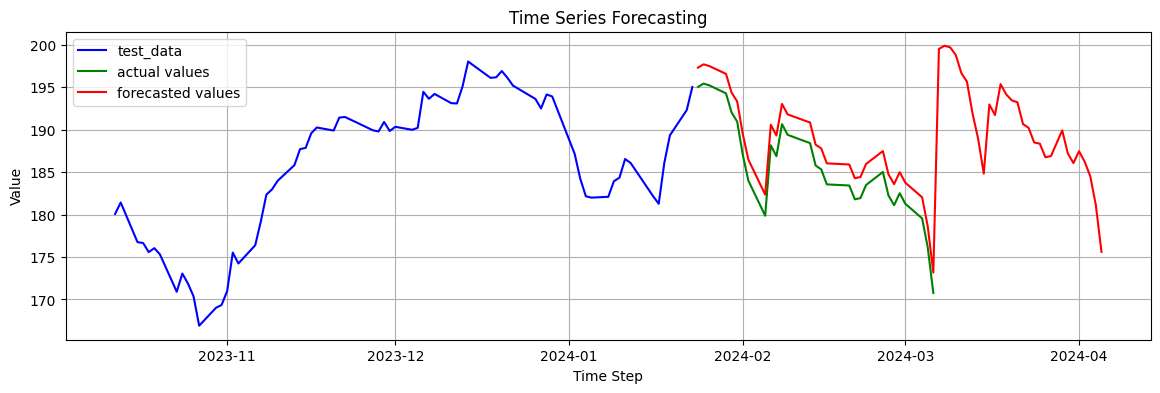

In [109]:
#set the size of the plot
plt.rcParams['figure.figsize'] = [14, 4]

#Test data
plt.plot(test_data.index[-100:-30], test_data.Open[-100:-30], label = "test_data", color = "b")
#reverse the scaling transformation
original_cases = scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0)).flatten()

#the historical data used as input for forecasting
plt.plot(test_data.index[-30:], original_cases, label='actual values', color='green')

#Forecasted Values
#reverse the scaling transformation
forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten()
# plotting the forecasted values
plt.plot(combined_index[-60:], forecasted_cases, label='forecasted values', color='red')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)